# Bearing Life Prediction Experiment
This is an example of using the the Seeq/Python module for applying Machine Learning models to cleansed data from Seeq.

# Project Setup
## Install dependencies

In [ ]:
import sys
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install seeq

## Import Libraries

In [37]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from numpy.random import seed
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense 
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers

from seeq import spy

In [38]:
from azureml.core import Workspace 
from azureml.core import Experiment
from azureml.mlflow import register_model
from azureml.core import Dataset, Datastore
from azureml.data.datapath import DataPath

experiment_name = 'Bearing_Failure_Prediction'
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

ae_bearing_demo	canadacentral	datalab-testing


In [39]:
from azureml.core import Experiment
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.start_logging()

# Get the Data

In [40]:
# Get the keyvault associated with this notebook
from azureml.core import Workspace
ws = Workspace.from_config()
keyvault = ws.get_default_keyvault()

## Log into Seeq with SPy

In [68]:
# Get the credentials from the secrets store
access_key_name = keyvault.get_secret(name="accesskey")
access_pwd = keyvault.get_secret(name="pwd")

# Login to Seeq
spy.login(url='https://explore.seeq.com/', username=access_key_name, password=access_pwd, ignore_ssl_errors=True)

## Search for Bearing Signals

In [42]:
vibration_signals = spy.search({
    'Name': '/^Vibration$/',
    'Path': 'Compressors Vibration Probes >> C23',
    'Scoped To': '7CC84C64-A14A-4DA2-AA6F-4C56733FADB2'
},)
# workbook = 'Seeq Integration with Python Machine Learning'
vibration_signals

,Name,Path,Scoped To,Time,Count,Result
0,/^Vibration$/,Compressors Vibration Probes >> C23,7CC84C64-A14A-4DA2-AA6F-4C56733FADB2,00:00:00.21,4,Success


,ID,Path,Asset,Name,Description,Type,Value Unit Of Measure,Datasource Name,Archived
0,5409E279-37DB-4D1A-B93C-1ADEDDDDD691,Compressors Vibration Probes >> C23,Vibration Probe 4,Vibration,NaN,CalculatedSignal,NaN,Seeq Data Lab,False
1,9BF8EE66-F835-45ED-A051-ED6F70272C24,Compressors Vibration Probes >> C23,Vibration Probe 2,Vibration,NaN,CalculatedSignal,NaN,Seeq Data Lab,False
2,A451911B-E83E-4AE5-A382-EE6A46277F20,Compressors Vibration Probes >> C23,Vibration Probe 3,Vibration,NaN,CalculatedSignal,NaN,Seeq Data Lab,False
3,E986B0F0-F358-454F-9F8C-DBAF94535C95,Compressors Vibration Probes >> C23,Vibration Probe 1,Vibration,NaN,CalculatedSignal,NaN,Seeq Data Lab,False


Find the condition giving time periods of normal operation...

In [43]:
bearing_norm_operation = spy.search({
    'Name': '/^Training Window$/',
    'Scoped To': '7CC84C64-A14A-4DA2-AA6F-4C56733FADB2'
},)
# workbook = 'Seeq Integration with Python Machine Learning'
bearing_norm_operation = bearing_norm_operation.iloc[0]

,Name,Scoped To,Time,Count,Result
0,/^Training Window$/,7CC84C64-A14A-4DA2-AA6F-4C56733FADB2,00:00:00.06,8,Success


## Pull Bearing Signal Data for the Window

First pull the Bearing Normal Operation Condition to find the timeperiod over which to retrive the data to train the model.

In [44]:
df_cond = spy.pull(bearing_norm_operation,start='2020-04-01 12:00:00', end='2020-07-15 12:00:00', grid=None)
start_time, end_time = df_cond.loc[0,['Capsule Start', 'Capsule End']]
df_cond

,ID,Path,Asset,Name,Count,Time,Result
0,624974A5-AC3D-4566-8151-2DC9D5F507B6,Compressors Vibration Probes >> C23,Vibration Probe 3,Training Window,1,00:00:00.03,Success


,Condition,Capsule Start,Capsule End,Capsule Is Uncertain
0,Compressors Vibration Probes >> C23 >> Vibrati...,2020-04-20 07:00:00+00:00,2020-05-04 07:00:00+00:00,False


Next pull the bearing vibration data.

In [45]:
df = spy.pull(vibration_signals, start=start_time, end=end_time, grid=None)
# create tabular dataset from Parquet files in datastore
datastore = ws.get_default_datastore()
df.head()

,ID,Path,Asset,Name,Count,Time,Result
0,5409E279-37DB-4D1A-B93C-1ADEDDDDD691,Compressors Vibration Probes >> C23,Vibration Probe 4,Vibration,672,00:00:00.04,Success
1,9BF8EE66-F835-45ED-A051-ED6F70272C24,Compressors Vibration Probes >> C23,Vibration Probe 2,Vibration,672,00:00:00.19,Success
2,A451911B-E83E-4AE5-A382-EE6A46277F20,Compressors Vibration Probes >> C23,Vibration Probe 3,Vibration,672,00:00:00.20,Success
3,E986B0F0-F358-454F-9F8C-DBAF94535C95,Compressors Vibration Probes >> C23,Vibration Probe 1,Vibration,672,00:00:00.19,Success


,Compressors Vibration Probes >> C23 >> Vibration Probe 4 >> Vibration,Compressors Vibration Probes >> C23 >> Vibration Probe 2 >> Vibration,Compressors Vibration Probes >> C23 >> Vibration Probe 3 >> Vibration,Compressors Vibration Probes >> C23 >> Vibration Probe 1 >> Vibration
2020-04-20 07:20:01+00:00,0.04317,0.07517,0.07304,0.06096
2020-04-20 07:50:01+00:00,0.04315,0.07446,0.07548,0.05934
2020-04-20 08:20:01+00:00,0.04322,0.07214,0.07462,0.05862
2020-04-20 08:50:01+00:00,0.04316,0.07372,0.07359,0.06003
2020-04-20 09:20:01+00:00,0.04313,0.07421,0.07541,0.06110


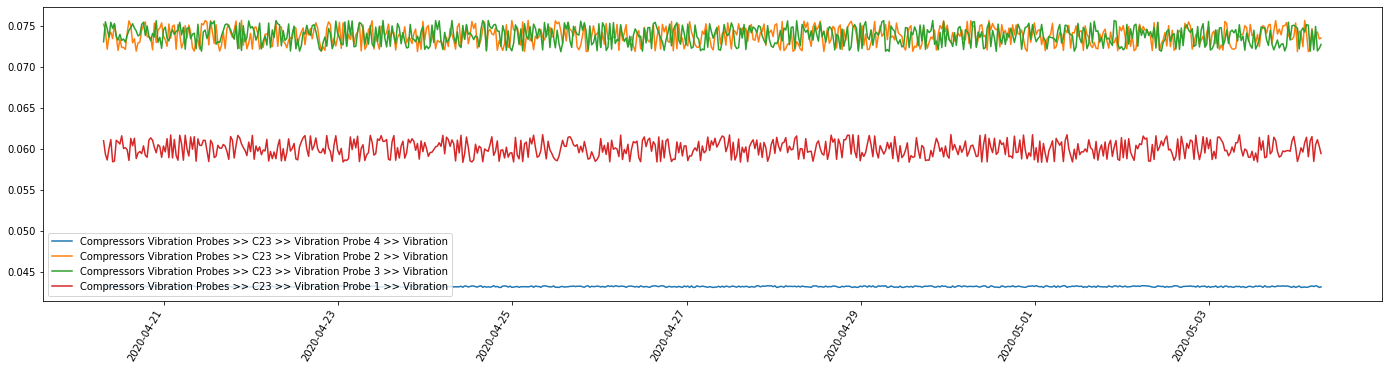

In [46]:
df.plot(figsize=(24,6), rot=60)

## Register the dataset

In [47]:
input_dataset = Dataset.Tabular.register_pandas_dataframe(df, datastore, name="bearing_life_training_data_set", description="Vibration data for training", show_progress=True)

Method register_pandas_dataframe: This is an experimental method, and may change at any time.<br/>For more information, see https://aka.ms/azuremlexperimental.


Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/d56e3256-21d1-4479-b49b-d6623f67e39b/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


# Develop the Machine Learning Model

## Standardize data

In [48]:
import pickle

# Standardization
names = df.columns
index = df.index
scaler = StandardScaler().fit(df)
scaled_df = pd.DataFrame(scaler.transform(df), index=index, columns=names)
pickle.dump(scaler, open('scaler.pkl','wb'))
run.upload_file(name='bearing_failure_exp_scaler', path_or_stream='scaler.pkl')

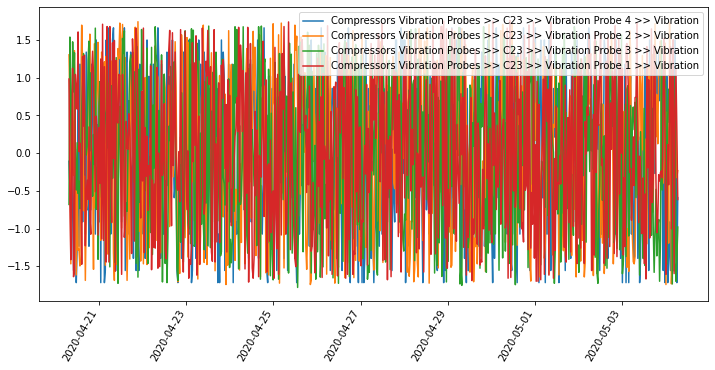

In [49]:
scaled_df.plot(figsize=(12,6), rot=60)

## Build the Artificial Neural Network

In [50]:
seed(9) # global seed for numpy
tf.random.set_seed(10) # global seed for tensorflow
activation = 'elu'
run.log("activation", activation)

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=activation,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(scaled_df.shape[1],)
               )
         )

model.add(Dense(2,activation=activation,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=activation,
                kernel_initializer='glorot_uniform'))

model.add(Dense(scaled_df.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')
run.log("optimizer", 'adam')
run.log("kernel_initalizer", 'glorot_uniform')


## Train Model

In [51]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10
X_train = scaled_df  # .sample(frac=1)
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)
model.save('bearing_model.h5')
run.upload_file(name='bearing_failure_exp_model', path_or_stream='bearing_model.h5')

Epoch 1/100
64/64 [==============================] - 1s 8ms/step - loss: 1.1586 - val_loss: 0.9988
Epoch 2/100
64/64 [==============================] - 0s 2ms/step - loss: 0.8765 - val_loss: 0.8172
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 0.7033 - val_loss: 0.7081
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 0.6340 - val_loss: 0.6374
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 0.5942 - val_loss: 0.6136
Epoch 6/100
64/64 [==============================] - 0s 2ms/step - loss: 0.5667 - val_loss: 0.6108
Epoch 7/100
64/64 [==============================] - 0s 2ms/step - loss: 0.5609 - val_loss: 0.6093
Epoch 8/100
64/64 [======

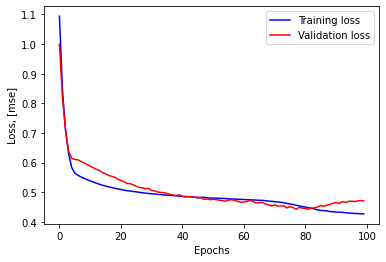

<Figure size 432x288 with 0 Axes>

In [52]:
plt.figure()
plt.plot(history.history['loss'], 'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()
run.log_image('Loss', plot=plt)

Determine the mean absolute errors and look at their distribution in the training set

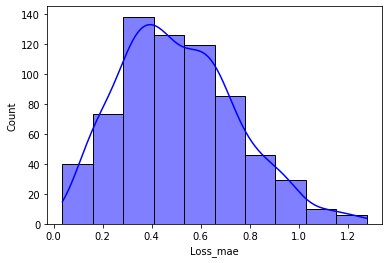

In [53]:
X_pred = model.predict(np.array(scaled_df))
X_pred = pd.DataFrame(X_pred, columns=scaled_df.columns)
X_pred.index = scaled_df.index

scored = pd.DataFrame(index=scaled_df.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-scaled_df), axis = 1)
plt.figure()
sns.histplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
run.log_image('Loss MAE', plot=plt)

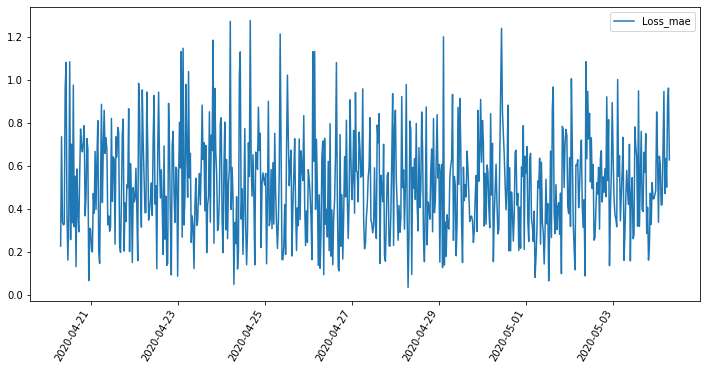

In [54]:
scored.plot(figsize=(12,6), rot=60)

Pick a threshold above the noise level from the above distribution

In [55]:
# pick a threshold above the noise level from the above distribution
thrs = 1.6
run.log("threshold", thrs)

# Apply ML Trained Model to New Data

As a Data Scientist you might want to validate your model though with test data

In [56]:
# Aux function to visualize MAE with respect to selected threshold
def loss_threshold_visualization(new_df, threshold, predictor):
    X_pred = predictor.predict(np.array(new_df))
    X_pred = pd.DataFrame(X_pred, columns=new_df.columns)
    X_pred.index = new_df.index

    scored = pd.DataFrame(index=new_df.index)
    scored['Loss_mae'] = np.mean(np.abs(X_pred-new_df), axis = 1)
    scored['Threshold'] = threshold
    scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
    return scored

Create a function to apply the trained model to new data

In [57]:
def anomaly_detection(new_df, threshold, predictor):
    X_pred = predictor.predict(np.array(new_df))
    X_pred = pd.DataFrame(X_pred, columns=new_df.columns)
    X_pred.index = new_df.index

    loss = np.mean(np.abs(X_pred-new_df), axis = 1)
    score = loss > threshold
    return pd.DataFrame(score * 1, index=new_df.index, columns=['BearingStatus'])


## Validate the model
We can validate with data outside of the training period. Make another call to get the data for a larger time period

In [58]:
# Make a new call to Seeq for new data 
new_df = spy.pull(vibration_signals, start='2020-04-15 12:00:00', end='2020-07-05 12:00:00', grid=None)
new_df.head()

,ID,Path,Asset,Name,Count,Time,Result
0,5409E279-37DB-4D1A-B93C-1ADEDDDDD691,Compressors Vibration Probes >> C23,Vibration Probe 4,Vibration,3783,00:00:00.17,Success
1,9BF8EE66-F835-45ED-A051-ED6F70272C24,Compressors Vibration Probes >> C23,Vibration Probe 2,Vibration,3783,00:00:00.51,Success
2,A451911B-E83E-4AE5-A382-EE6A46277F20,Compressors Vibration Probes >> C23,Vibration Probe 3,Vibration,3783,00:00:00.57,Success
3,E986B0F0-F358-454F-9F8C-DBAF94535C95,Compressors Vibration Probes >> C23,Vibration Probe 1,Vibration,3783,00:00:00.51,Success


,Compressors Vibration Probes >> C23 >> Vibration Probe 4 >> Vibration,Compressors Vibration Probes >> C23 >> Vibration Probe 2 >> Vibration,Compressors Vibration Probes >> C23 >> Vibration Probe 3 >> Vibration,Compressors Vibration Probes >> C23 >> Vibration Probe 1 >> Vibration
2020-04-17 02:20:01+00:00,0.04311,0.07384,0.07277,0.05933
2020-04-17 02:50:01+00:00,0.04310,0.07230,0.07348,0.06129
2020-04-17 03:20:01+00:00,0.04318,0.07192,0.07400,0.05995
2020-04-17 03:50:01+00:00,0.04320,0.07448,0.07511,0.06005
2020-04-17 04:20:01+00:00,0.04322,0.07238,0.07510,0.05870


Scale the new df but make sure it is scaled using the previous parameters from the scaler used for the training set

In [59]:
# It is important to used the previously defined standarization scaler
new_scaled_df = pd.DataFrame(scaler.transform(new_df), 
                             index=new_df.index, 
                             columns=new_df.columns)

In [60]:
# to visualize MAE with respect to the chosen threshold
loss_level = loss_threshold_visualization(new_scaled_df, thrs, model)

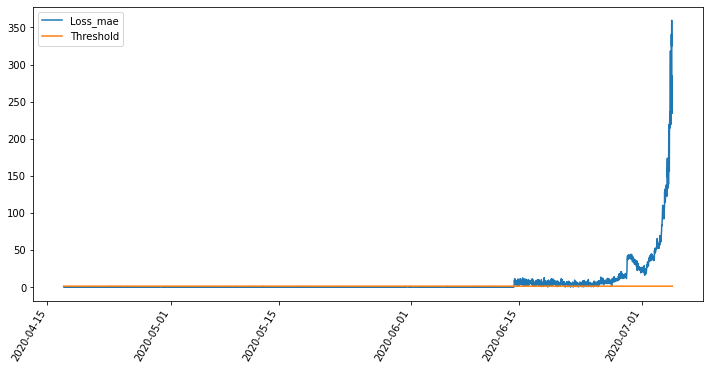

In [61]:
loss_level.plot(figsize=(12,6), rot=60)

# Create and push a new signal with the status of the bearing health


Status 0 means "normal" Status 1 means "abnormal"

In [62]:
status = anomaly_detection(new_scaled_df, thrs, model)
output_dataset = Dataset.Tabular.register_pandas_dataframe(status, datastore, name="bearing_life_output_set", description="Output after training", show_progress=True)
status.head()

Method register_pandas_dataframe: This is an experimental method, and may change at any time.<br/>For more information, see https://aka.ms/azuremlexperimental.


Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/81b25d74-c68f-454e-b48b-137f6970dae6/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


,BearingStatus
2020-04-17 02:20:01+00:00,0
2020-04-17 02:50:01+00:00,0
2020-04-17 03:20:01+00:00,0
2020-04-17 03:50:01+00:00,0
2020-04-17 04:20:01+00:00,0


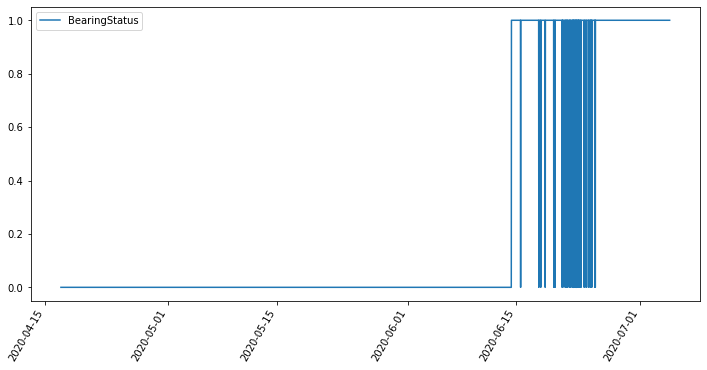

In [63]:
status.plot(figsize=(12,6), rot=60)

## Register the Model

In [64]:
from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration
details = run.get_details()
runId = details['runId']

model = run.register_model(model_name='bearing-life-tensorflow-model',
                          model_path='bearing_failure_exp_model', 
                          model_framework=Model.Framework.TENSORFLOW, 
                          datasets=[('training_data_set', input_dataset),('output_data_set', output_dataset)],
                          model_framework_version=keras.__version__, 
                          description='Bearing life model',
                          tags={'area': 'Bearing Life', 'type': 'ANN'})


In [ ]:
model.update(sample_input_dataset=input_dataset, sample_output_dataset=output_dataset)

## Push signal back to Seeq

In [65]:
#create a status signal in Seeq

spy.push(status, metadata=pd.DataFrame({
    'Interpolation Method': {
        'BearingStatus': 'step'
    },
    'Type': 'Signal',
    'Name': 'Bearing Status',
    'Model Version': model.version
}), workbook='7CC84C64-A14A-4DA2-AA6F-4C56733FADB2', worksheet = '7. Bearing Status Prediction Output')

,ID,Name,Count,Time,Result
BearingStatus,6F80A16E-0FD3-4484-98C5-36CF8B4D2CF8,Bearing Status,3783,00:00:00.65,Success


,Interpolation Method,Type,Name,Model Version,Datasource Class,Datasource ID,Data ID,ID,Push Result,Push Count,Push Time
BearingStatus,step,StoredSignal,Bearing Status,8,Seeq Data Lab,Seeq Data Lab,[7CC84C64-A14A-4DA2-AA6F-4C56733FADB2] {Signal...,6F80A16E-0FD3-4484-98C5-36CF8B4D2CF8,Success,3783,0:00:00.651201


In [66]:
run.complete()